In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT

### Define components of algorithm

In [2]:
def initialize_qubits(given_circuit, n, m):
    
    given_circuit.h(range(n))
    given_circuit.x(n+m-1)

In [3]:
# Define modular exponentiation 

def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, x)
    c_U = U.control()
    return c_U

In [4]:
def modular_exponentiation(given_circuit, n, m, a):
    
    for x in range(n):
        given_circuit.append(a_x_mod15(a, 2**x), [x] + list(range(n, n+m)))         

### Construct algorithm using components

In [7]:
def shor_program(n, m, a):
    
    # set up quantum circuit
    shor = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(shor, n, m)
    shor.barrier()

    # apply modular exponentiation
    modular_exponentiation(shor, n, m, a)
    shor.barrier()

    # apply inverse QFT
    apply_iqft(shor, range(n))

    # measure the first n qubits
    shor.measure(range(n), range(n))
    
    return shor
    
n = 4; m = 4; a = 7
mycircuit = shor_program(n, m, a)
mycircuit.draw(output='text')

┌───┐ ░                                                              ░ »
q_0: ┤ H ├─░────────■─────────────────────────────────────────────────────░─»
     ├───┤ ░        │                                                     ░ »
q_1: ┤ H ├─░────────┼──────────────■──────────────────────────────────────░─»
     ├───┤ ░        │              │                                      ░ »
q_2: ┤ H ├─░────────┼──────────────┼──────────────■───────────────────────░─»
     ├───┤ ░        │              │              │                       ░ »
q_3: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────■────────░─»
     └───┘ ░ ┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐ ░ »
q_4: ──────░─┤0     │      ├┤0     │      ├┤0     │      ├┤0     │      ├─░─»
           ░ │             ││             ││             ││             │ ░ »
q_5: ──────░─┤1            ├┤1            ├┤1            ├┤1            ├─░─»
           ░ │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │ ░ »
q_6: ──────░─┤2            ├┤2            ├┤2            ├┤2            ├─░─»
     ┌───┐ ░ │             ││             ││             ││             │ ░ »
q_7: ┤ X ├─░─┤3            ├┤3            ├┤3            ├┤3            ├─░─»
     └───┘ ░ └─────────────┘└─────────────┘└─────────────┘└─────────────┘ ░ »
c_0: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_1: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_2: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
c_3: ═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───────┐┌─┐         
«q_0: ┤0      ├┤M├─────────
«     │       │└╥┘┌─┐      
«q_1: ┤1      ├─╫─┤M├──────
«     │  iqft │ ║ └╥┘┌─┐   
«q_2: ┤2      ├─╫──╫─┤M├───
«     │       │ ║  ║ └╥┘┌─┐
«q_3: ┤3      ├─╫──╫──╫─┤M├
«     └───────┘ ║  ║  ║ └╥┘
«q_4: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_5: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_6: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_7: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«c_0: ══════════╩══╬══╬══╬═
«                  ║  ║  ║ 
«c_1: ═════════════╩══╬══╬═
«                     ║  ║ 
«c_2: ════════════════╩══╬═
«                        ║ 
«c_3: ═══════════════════╩═
«

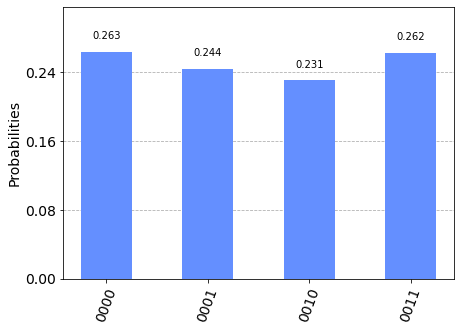

In [8]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=1000).result().get_counts(mycircuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [9]:
for measured_value in counts:
    print(f"Measured {int(measured_value[::-1], 2)}")

Measured 0
Measured 12
Measured 8
Measured 4


In [10]:
# Classical post-processing

from math import gcd

for measured_value in counts:
    measured_value_decimal = int(measured_value[::-1], 2)
    print(f"Measured {measured_value_decimal}")
    
    if measured_value_decimal % 2 != 0:
        print("Failed. Measured value is not an even number")
        continue
    x = int((a ** (measured_value_decimal/2)) % 15)
    if (x + 1) % 15 == 0:
        print("Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, 15), gcd(x - 1, 15)
    print(guesses)

Measured 0
(1, 15)
Measured 12
(5, 3)
Measured 8
(1, 15)
Measured 4
(5, 3)
